# __Springboard Data Science Capstone 3 Project__
# _Predicting the Price of Energy_

### Pre-Processing & Modeling

##### _Ben Takacs_
###### __Python version 3.10.4__

### __Imports and File Location__

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions import load_csv_data

from sklearn import preprocessing

### __Load Data__

In [5]:
df = pd.read_csv('./data/df1.csv', index_col=0)
df

,"Average Price of Electricity to Ultimate Customers, Residential",Total Renewable Energy Consumption,Total Petroleum Consumed by the Residential Sector
Month,,,
1990-02-01,7.48,0.321465,143.972
1990-03-01,7.57,0.353956,129.117
1990-04-01,7.69,0.334136,108.024
1990-05-01,7.96,0.317791,94.930
1990-06-01,8.10,0.289276,87.671
...,...,...,...
2024-05-01,16.43,0.758321,53.691
2024-06-01,16.42,0.742351,40.900
2024-07-01,16.63,0.733689,31.619


Average price is in units of cents per kilowatt hour, including taxes.
Renewable energy consumption is in units of quadrillion Btu (10^15)
Petroleum consumption is in units of trillion Btu (10^12)
Need to convert  energies to same unit.
Also going to rename columsn to something easier.

In [10]:
df.rename(columns={'Average Price of Electricity to Ultimate Customers, Residential':'Price', 'Total Renewable Energy Consumption':'Renewable', 'Total Petroleum Consumed by the Residential Sector':'Petroleum'}, inplace=True)
df.Renewable *= 1e3
df

,Price,Renewable,Petroleum
Month,,,
1990-02-01,7.48,321.465,143.972
1990-03-01,7.57,353.956,129.117
1990-04-01,7.69,334.136,108.024
1990-05-01,7.96,317.791,94.930
1990-06-01,8.10,289.276,87.671
...,...,...,...
2024-05-01,16.43,758.321,53.691
2024-06-01,16.42,742.351,40.900
2024-07-01,16.63,733.689,31.619


Renewable and Petroleum now have same units (trillion Btu)

### __Scale Data__

In [12]:
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=df.columns)
scaled_df.head()

,Price,Renewable,Petroleum
0,-1.325657,-1.017545,0.956113
1,-1.288906,-0.773129,0.620514
2,-1.239906,-0.922226,0.143989
3,-1.129654,-1.045182,-0.151826
4,-1.072487,-1.259688,-0.315818


<Figure size 640x480 with 0 Axes>

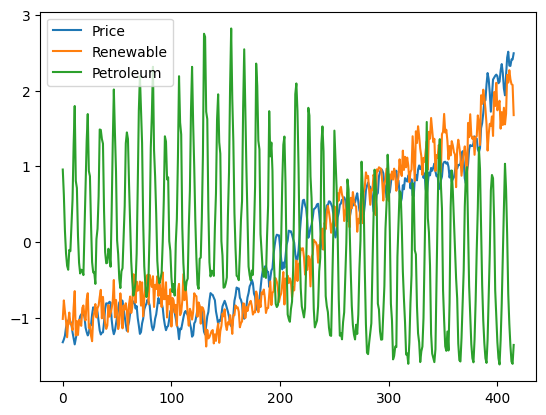

In [14]:
plt.figure()
scaled_df.plot()
plt.show()